## NREL National Solar Radiation Database (NSRDB) - HSDS Demo

This notebook demonstrates basic usage of the National Renewable Energy Laboratory (NREL) National Solar Radiation Database (NSRDB) data. The data is provided from Amazon Web Services using the HDF Group's Highly Scalable Data Service (HSDS).

For this to work you must first install h5pyd:

```
pip install --user h5pyd
```

Next you'll need to configure HSDS:

```
hsconfigure
```

and enter at the prompt:

```
hs_endpoint = https://developer.nrel.gov/api/hsds
hs_username = None
hs_password = None
hs_api_key = 3K3JQbjZmWctY0xmIfSYvYgtIcM3CN0cb1Y2w9bf
```

*The example API key here is for demonstation and is rate-limited per IP. To get your own API key, visit https://developer.nrel.gov/signup/*

You can also add the above contents to a configuration file at ~/.hscfg

In [1]:
%matplotlib inline
import h5pyd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.spatial import cKDTree

## Basic Usage

The NSRDB is provided in annual .h5 files and currently spans 1998-2018.  
Each year can be accessed from /nrel/nsrdb/nsrdb_${year}.h5

In [2]:
# Open the desired year of nsrdb data
# server endpoint, username, password is found via a config file
# f = h5pyd.File("/nrel/nsrdb/v3/nsrdb_2012.h5", 'r')
f = h5pyd.File("/nrel/nsrdb/v3/tmy/nsrdb_tmy-2020.h5", 'r') #nrel-pds-nsrdb/v3/tmy


In [3]:
list(f.attrs)  # list attributes belonging to the root group

['version']

In [4]:
f.attrs['version']   # attributes can be used to provide desriptions of the content

'3.2.0'

## Datasets

In [5]:
list(f)  # list the datasets in the file

['air_temperature',
 'alpha',
 'aod',
 'asymmetry',
 'cld_opd_dcomp',
 'cld_reff_dcomp',
 'clearsky_dhi',
 'clearsky_dni',
 'clearsky_ghi',
 'cloud_press_acha',
 'cloud_type',
 'coordinates',
 'dew_point',
 'dhi',
 'dni',
 'fill_flag',
 'ghi',
 'meta',
 'ozone',
 'relative_humidity',
 'solar_zenith_angle',
 'ssa',
 'surface_albedo',
 'surface_pressure',
 'time_index',
 'tmy_year',
 'tmy_year_short',
 'total_precipitable_water',
 'wind_direction',
 'wind_speed']

In [6]:
# Datasets are stored in a 2d array of time x location
dset = f['ghi']
dset.shape

(8760, 2018392)

In [8]:
# Extract datetime index for datasets
time_index = pd.to_datetime(f['time_index'][...].astype(str))
time_index # Temporal resolution is 60min

OSError: Error retrieving data: None

In [12]:
# Locational information is stored in either 'meta' or 'coordinates'
meta = pd.DataFrame(f['meta'][...])
meta.head()

,latitude,longitude,elevation,timezone,country,state,county,urban,population,landcover
0,-19.99,-175.259995,0.0,13,b'None',b'None',b'None',b'None',-9999,210
1,-19.99,-175.220001,0.0,13,b'None',b'None',b'None',b'None',-9999,210
2,-19.99,-175.179993,0.0,13,b'None',b'None',b'None',b'None',-9999,210
3,-19.99,-175.139999,0.0,13,b'None',b'None',b'None',b'None',-9999,210
4,-19.99,-175.100006,0.0,13,b'None',b'None',b'None',b'None',-9999,210


In [13]:
# Datasets have been saved as integers
dset.dtype

dtype('uint16')

In [14]:
dset.shape[0] * dset.shape[1] * 2 * 10**-9 # 35 GB per dataset!

35.36222784

In [15]:
dset.chunks # Chunked by week

(1344, 744)

In [16]:
dset.chunks[0] * dset.chunks[1] * 2 * 10**-6 # 2 MB per chunk

1.9998719999999999

In [17]:
# To convert dataset values back to floats use the 'psm_scale_factor'
dset.attrs['psm_scale_factor'] # Irradiance values have been truncated to integer precision

1.0

In [18]:
# wind speed on the other hand has single decimal percision when scaled by 10
scale_factor = f['wind_speed'].attrs['psm_scale_factor']
units = f['wind_speed'].attrs['psm_units']
print('wind_speed scale factor = ', scale_factor)
print('wind_speed units after unscaling = ', units)
f['wind_speed'][0, 0] / scale_factor # divide by scale_factor to return native value

wind_speed scale factor =  10.0
wind_speed units after unscaling =  m/s


5.5

## Time-slicing

Get the time_index from the server and convert to a pandas DatetimeIndex for convenience:

In [19]:
time_index = pd.to_datetime(f['time_index'][...].astype(str))
time_index

DatetimeIndex(['2020-01-01 00:30:00+00:00', '2020-01-01 01:30:00+00:00',
               '2020-01-01 02:30:00+00:00', '2020-01-01 03:30:00+00:00',
               '2020-01-01 04:30:00+00:00', '2020-01-01 05:30:00+00:00',
               '2020-01-01 06:30:00+00:00', '2020-01-01 07:30:00+00:00',
               '2020-01-01 08:30:00+00:00', '2020-01-01 09:30:00+00:00',
               ...
               '2020-12-31 14:30:00+00:00', '2020-12-31 15:30:00+00:00',
               '2020-12-31 16:30:00+00:00', '2020-12-31 17:30:00+00:00',
               '2020-12-31 18:30:00+00:00', '2020-12-31 19:30:00+00:00',
               '2020-12-31 20:30:00+00:00', '2020-12-31 21:30:00+00:00',
               '2020-12-31 22:30:00+00:00', '2020-12-31 23:30:00+00:00'],
              dtype='datetime64[ns, UTC]', length=8760, freq=None)

Extract indexes for a particular span of time:

In [48]:
march = time_index.month == 3
timestep = np.where(march)[0]

Or a particular date:

In [55]:
timestep = np.where(time_index == '2020-07-04 00:30:00')[0][0]
timestep

4416

## Map Data

In [56]:
# Extract coordinates (lat, lon)
print(dict(f['coordinates'].attrs))
coords = f['coordinates'][...]

{'description': '(latitude, longitude)'}


In [57]:
# Choose location for which to fetch data since otherwise too large dataset

# %%
TX = meta.loc[meta['state'] == b'Texas'] # Note .h5 saves strings as bit-strings
TX.head()


,latitude,longitude,elevation,timezone,country,state,county,urban,population,landcover
57215,30.690001,-105.019997,1023.320007,-7,b'United States',b'Texas',b'Hudspeth',b'None',0,130
57471,30.730000,-105.099998,972.687500,-6,b'United States',b'Texas',b'Hudspeth',b'None',3,130
57472,30.730000,-105.059998,1005.700012,-7,b'United States',b'Texas',b'Hudspeth',b'None',0,130
57473,30.730000,-105.019997,1158.300049,-7,b'United States',b'Texas',b'Hudspeth',b'None',0,130
57730,30.770000,-105.139999,989.080017,-7,b'United States',b'Texas',b'Hudspeth',b'None',0,130


In [58]:
timestep

4416

In [59]:
# dset = f['ghi']
data = dset[timestep][TX.index]  # full-resolution subset
# data = dset[timestep, ::10]   # extract every 10th location at a particular time

df = TX[['longitude', 'latitude']].copy()
# df = pd.DataFrame() # Combine data with coordinates in a DataFrame
# df['longitude'] = coords[::10, 1]
# df['latitude'] = coords[::10, 0]
df['ghi'] = data / dset.attrs['psm_scale_factor'] # unscale dataset

In [60]:
df.shape

(40709, 3)

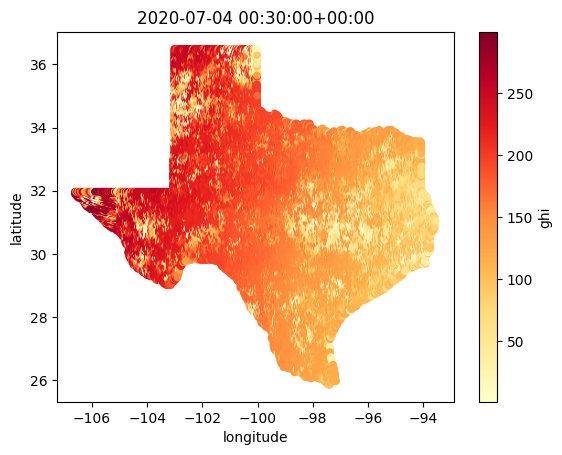

In [61]:
df.plot.scatter(x='longitude', y='latitude', c='ghi',
                colormap='YlOrRd',
                title=str(time_index[timestep]))
plt.show()

In [62]:
# Full resolution subset of Colorado
meta = pd.DataFrame(f['meta'][...])
CA = meta.loc[meta['state'] == b'California'] # Note .h5 saves strings as bit-strings
CA.head()

KeyboardInterrupt: 

In [97]:
%time data = dset[timestep][CA.index]  # full-resolution subset
df = CA[['longitude', 'latitude']].copy()
df['ghi'] = data / dset.attrs['psm_scale_factor']
df.shape

CPU times: user 31.4 ms, sys: 27.3 ms, total: 58.8 ms
Wall time: 3.96 s


(26010, 3)

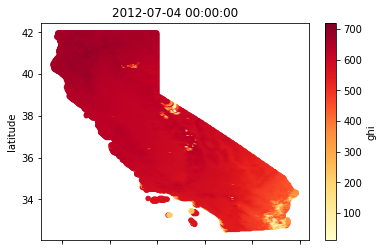

In [98]:
df.plot.scatter(x='longitude', y='latitude', c='ghi',
                colormap='YlOrRd',
                title=str(time_index[timestep]))
plt.show()

## Nearest Timeseries for given Lat/Lon

In [63]:
# Unlike the gridded WTK data the NSRDB is provided as sparse time-series dataset.
# The quickest way to find the nearest site it using a KDtree

dset_coords = f['coordinates'][...]
tree = cKDTree(dset_coords)
def nearest_site(tree, lat_coord, lon_coord):
    lat_lon = np.array([lat_coord, lon_coord])
    dist, pos = tree.query(lat_lon)
    return pos

NewYorkCity = (40.7128, -74.0059)
NewYorkCity_idx = nearest_site(tree, NewYorkCity[0], NewYorkCity[1] )

print("Site index for New York City: \t\t {}".format(NewYorkCity_idx))
print("Coordinates of New York City: \t {}".format(NewYorkCity))
print("Coordinates of nearest point: \t {}".format(dset_coords[NewYorkCity_idx]))

Site index for New York City: 		 1244690
Coordinates of New York City: 	 (40.7128, -74.0059)
Coordinates of nearest point: 	 [ 40.73 -74.02]


In [64]:
# Get the entire timeseries data for a point in NYC
tseries = dset[:, NewYorkCity_idx] / dset.attrs['psm_scale_factor']

In [65]:
len(tseries)   # 1 years * 365 days * 24 hours * 30 minutes

8760

Text(0.5, 1.0, 'NYC ghi in 2012')

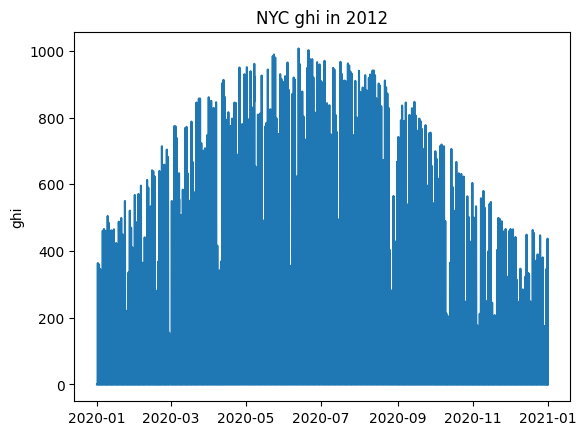

In [66]:
plt.plot(time_index, tseries)
plt.ylabel("ghi")
plt.title("NYC ghi in 2012")

## GHI Statistics

In [67]:
df = pd.DataFrame({'ghi': tseries}, index=time_index)
df["year"] = df.index.year
df["month"] = df.index.month
df["day"] = df.index.day
df["hour"] = df.index.hour

agg = df.groupby(["month","hour"]).mean()
agg = agg.reset_index().pivot(index="month",columns="hour",values="ghi")
agg

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
month,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,226.774194,288.354839,318.645161,327.354839,294.290323,240.516129,125.483871,28.451613,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,295.857143,390.000000,428.178571,439.321429,411.785714,339.607143,228.892857,91.000000,1.857143,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,381.612903,473.548387,512.645161,553.096774,507.580645,382.032258,278.225806,149.193548,46.193548,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,543.433333,565.066667,585.733333,589.366667,583.500000,499.600000,362.166667,236.166667,106.066667,5.700000
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,571.483871,619.451613,710.870968,651.967742,638.096774,541.322581,407.741935,300.161290,167.258065,42.774194
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,584.966667,695.966667,705.400000,720.266667,661.500000,572.033333,490.300000,339.900000,181.766667,67.133333
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,615.419355,710.290323,704.193548,685.935484,685.064516,570.129032,506.129032,353.354839,195.161290,64.677419
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,568.354839,608.193548,660.258065,655.354839,590.967742,547.806452,434.387097,288.870968,139.096774,24.096774
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,501.300000,587.800000,597.833333,562.400000,517.200000,405.133333,311.933333,159.133333,46.400000,0.000000


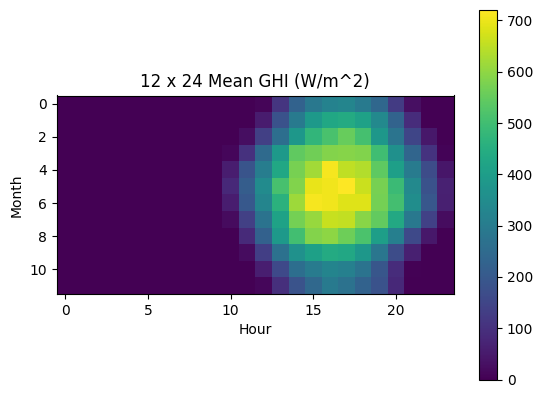

In [68]:
plt.imshow(agg)
plt.xlabel("Hour")
plt.ylabel("Month")
plt.title("12 x 24 Mean GHI (W/m^2)")
plt.colorbar()